In [218]:
import numpy as np
import pandas as pd
import scipy

import hdf5plugin
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec 
%matplotlib inline

import warnings

In [219]:
df = pd.read_csv('/mnt_blpc3/datax/scratch/andresl/starlink-pipeline-runs/sample-run2/batches/batch_038.csv')
df

,frequency_index,frequency,kurtosis,snr,width,flags,source file
0,39718912,11702.989770,7.521135,0.735990,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
1,39719424,11702.989485,7.542027,0.735072,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
2,40072192,11702.001941,1701.201800,11.573913,0.000007,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
3,40072704,11702.001942,1701.095700,11.576772,0.000007,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
4,40427008,11701.011018,7.210162,0.797517,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
5,40427520,11701.011020,7.079360,0.801370,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
6,40604672,11700.514112,87.669440,1.759433,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
7,40605184,11700.514113,89.604780,1.755988,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
8,40700416,11700.247641,104.763700,1.468319,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...
9,40700928,11700.247643,107.313520,1.457631,0.000006,NaN,/datag/pipeline/AGBT24B_999_18/blc03_blp03/blc...


In [220]:
f = h5py.File(df['source file'].iloc[0])
fch1 = f['data'].attrs['fch1']
foff = f['data'].attrs['foff']
nchans = f['data'].attrs['nchans']
tsamp = f['data'].attrs['tsamp']
WINDOW_SIZE = 2**10

In [221]:
def signal_model(x, mean, stdev, amplitude, noise):
    exponent = -0.5 * ((x - mean) / stdev)**2
    return noise + amplitude * np.exp(exponent)

def fit_gaussian_to_slice(freq_array: np.ndarray, slice_data: np.ndarray):
    return scipy.optimize.curve_fit(
        signal_model, 
        freq_array, 
        slice_data, 
        p0=[
            freq_array[np.argmax(slice_data)], 
            np.abs(foff),
            np.max(slice_data) - np.median(slice_data),
            np.median(slice_data)
        ],
        # slow, screws up scale for some signals
        bounds=np.array([
            (freq_array[-1], freq_array[0]),
            (0, np.inf),
            (np.median(slice_data)*0.25, np.inf),
            (0, np.inf)
        ]).T,
        max_nfev=10_000
    )

def fit_frequency_gaussians(freq_array: np.ndarray, block: np.ndarray):
        """
        Fits a Gaussian to each frequency slice of the block.
        Returns parameters and covariance for each slice, with dimensions (num_slices, 4) and (num_slices, 4, 4).
        Failed fits result in NaN parameters for that slice."""
        all_params = []
        all_covs = []
        for i in range(block.shape[0]):
            slice_data = block[i, :]
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    params, cov = fit_gaussian_to_slice(freq_array, slice_data)
            except (RuntimeError, ValueError, scipy.optimize.OptimizeWarning) as e:
                # print(e)
                # Return NaN parameters for failed fits
                params = np.full((4,), np.nan)
                cov = np.full((4, 4), np.nan)
            all_params.append(params)
            all_covs.append(cov)
        params = np.array(all_params)
        covs = np.array(all_covs)
        return params, covs

def zap_dc(block, l_idx):
    r_idx = l_idx + WINDOW_SIZE
    COARSE_PER_FINE = 2**20

    r_to_spike = (r_idx + COARSE_PER_FINE//2) % COARSE_PER_FINE
    if r_to_spike > WINDOW_SIZE: return

    spike_idx = WINDOW_SIZE - r_to_spike
    block[:, spike_idx] = (block[:, spike_idx-1] + block[:, spike_idx+1])/2

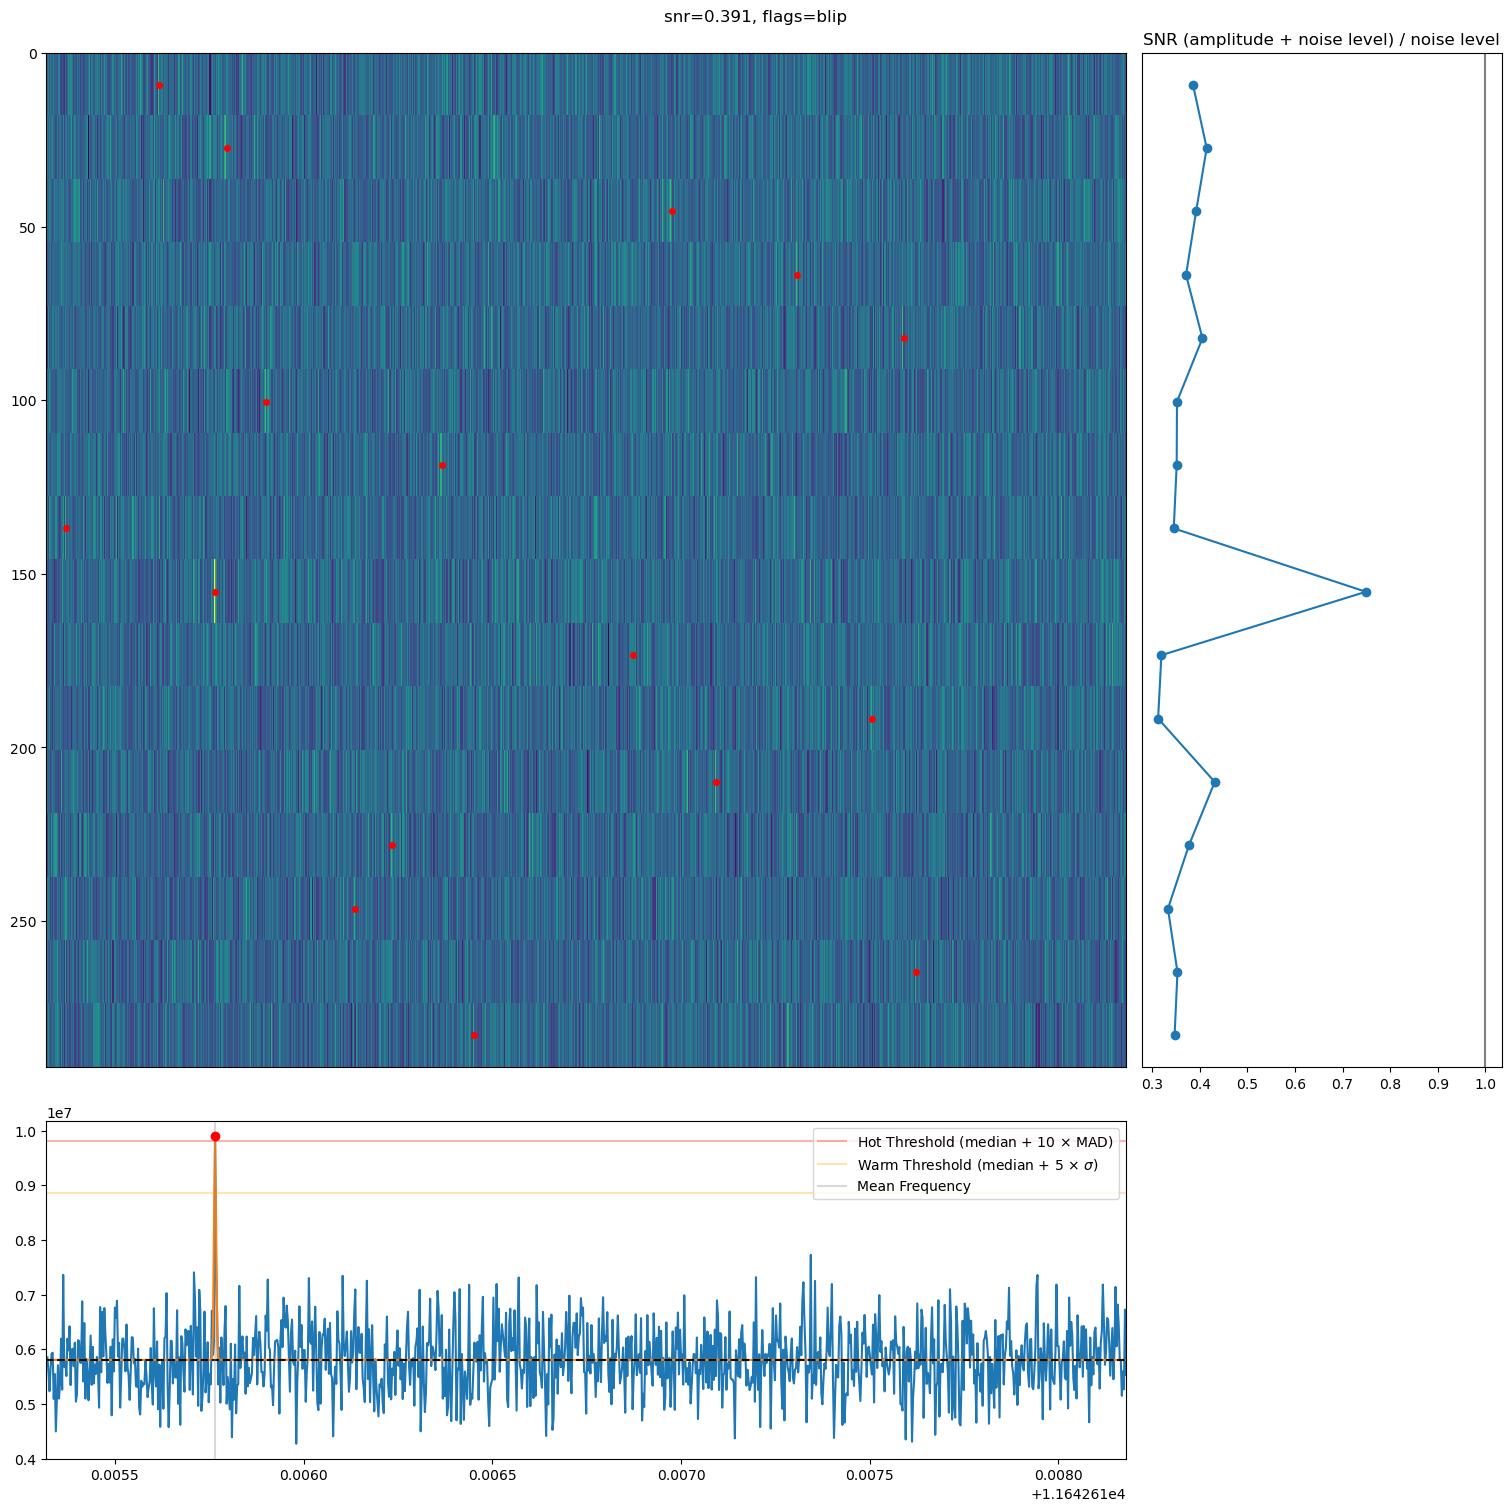

In [227]:
def make_figure(hit, title=None):
    if title is None:
        title = hit['flags'] if not pd.isna(hit['flags']) else '(no flags)'
        title = hit.name + title

    SLICE_IDX = 8

    l_idx = hit['frequency_index']
    data: h5py.Dataset = f['data'][:, 0, l_idx : l_idx+WINDOW_SIZE] # type: ignore
    zap_dc(data, l_idx)
    freqs = np.linspace(
        fch1 + l_idx*foff, 
        fch1 + (l_idx + data.shape[1])*foff,
        data.shape[1],
        endpoint=False
    )
    times = (np.arange(data.shape[0]) + 0.5) * tsamp
    params, _ = fit_frequency_gaussians(freqs, data)

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 1], height_ratios=[3, 1])

    im_ax = fig.add_subplot(gs[0, 0])
    snr_ax = fig.add_subplot(gs[0, 1], sharey=im_ax)
    slice_ax = fig.add_subplot(gs[1, 0], sharex=im_ax)

    snr = params[:, 2] * np.sqrt(np.pi / np.log(2)) / (2 * params[:, 3])
    snr_ax.plot(snr, times, marker='o')
    if np.min(snr) < 2:
        snr_ax.axvline(1.0, color='gray')
    snr_ax.set_title('SNR (amplitude + noise level) / noise level')
    snr_ax.yaxis.set_visible(False) 

    im_ax.imshow(
        data,
        extent=(
            fch1 + foff*l_idx, fch1 + foff*(l_idx + data.shape[1]),
            data.shape[0] * tsamp, 0
        ),
        aspect='auto',
        interpolation='none'
    )
    im_ax.errorbar(params[:, 0], times, color='red', markersize=4, xerr=params[:, 1], fmt='o')
    im_ax.invert_xaxis()
    im_ax.xaxis.set_visible(False)  # Hide x-axis on main plot

    slice_data = data[SLICE_IDX, :]
    slice_ax.plot(freqs, slice_data)
    slice_ax.plot(freqs, signal_model(freqs, *params[SLICE_IDX]))

    slice_median = params[SLICE_IDX, 3]
    slice_ax.axhline(slice_median, alpha = 0.9, color='black', linestyle='--')

    hot_threshold = slice_median + 10*scipy.stats.median_abs_deviation(slice_data)
    slice_ax.axhline(hot_threshold, alpha=0.3, color='red', label='Hot Threshold (median + 10 $\\times$ MAD)')

    warm_threshold = slice_median + 5*np.std(slice_data)
    slice_ax.axhline(warm_threshold, alpha=0.3, color='orange', label='Warm Threshold (median + 5 $\\times\\ \\sigma$)')

    slice_freq = params[SLICE_IDX, 0]
    slice_ax.axvline(slice_freq, alpha=0.3, color='gray', label='Mean Frequency')

    slice_ax.scatter(x=freqs[np.argmax(slice_data)], y=np.max(slice_data), color='red', zorder=10)

    # slice_ax.set_yscale('log')

    slice_ax.legend()

    fig.suptitle(title)
    return fig
hit = df.sample().iloc[0]
# hit = df.loc[577]
make_figure(hit, f'snr={hit['snr']:.3g}, flags={hit['flags']}')
plt.show()

In [211]:
hit.name

np.int64(4)

In [212]:
strip = f['data'][8, 0, hit.frequency_index : hit.frequency_index+WINDOW_SIZE]

mad = scipy.stats.median_abs_deviation(strip)
sig = np.max(strip) - np.median(strip)
sig, mad * 10

(np.float32(10313460.0), np.float32(4053405.0))

In [213]:
def save_hit_fig(hit, title=None, filename='image.png'):
    fig = make_figure(hit, title)
    fig.savefig(filename, transparent=False)

    plt.close(fig)

In [214]:
!rm scratch_images/*

In [215]:
df_normal = df[df['flags'].isna()]
if len(df_normal) > 25:
    df_normal = df_normal.sample(25) 
for i, (idx, normal_hit) in enumerate(df_normal.iterrows()):
    save_hit_fig(normal_hit, title=f'normal {idx}, freq={normal_hit['frequency']}, snr={normal_hit['snr']:.3g}', filename=f'scratch_images/normal_{i:>02}.png')

In [216]:
blip_df = df[df['flags'].str.contains('blip', na=False)]
if len(blip_df) > 25:
    blip_df = blip_df.sample(25)
for i, (idx, blip_hit) in enumerate(blip_df.iterrows()):
    save_hit_fig(blip_hit, title=f'blip {idx}, freq={normal_hit['frequency']}, snr={normal_hit['snr']:.3g},  {blip_hit['flags']}', filename=f'scratch_images/blip_{i:>03}.png')

In [217]:
bright_df = df[df['snr'] > 10]
if len(bright_df) >= 25:
    bright_df = bright_df.sample(25)
for i, (idx, bright_hit) in enumerate(bright_df.iterrows()):
    save_hit_fig(bright_hit, title=f'bright {idx}, freq={normal_hit['frequency']}, snr={bright_hit['snr']:.3g}, {bright_hit['flags']}', filename=f'scratch_images/bright_{i:>03}.png')

In [ ]:
normal_hit

frequency_index                                               610816
frequency                                               11249.756023
kurtosis                                                   61.765984
snr                                                        77.928703
width                                                       0.000048
flags                                                            NaN
source file        /datag/pipeline/AGBT20B_999_33/blc00_blp00/blc...
Name: 151, dtype: object